### 1.Import das Bibliotecas

In [441]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
from scipy import stats
from sklearn.preprocessing import KBinsDiscretizer
from feature_engine.creation import MathFeatures
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Bibliotecas para avaliação do modelo
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


warnings.filterwarnings('ignore')

In [419]:
base_path = r"C:\Users\bruno\OneDrive\Desktop\Modelos\Classification"
file_path = f"{base_path}\\dataset\\heart_failure_clinical_records_dataset.csv"

In [420]:
df = pd.read_csv(file_path)
df

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


#### 2. Dicionário de Dados

- **`age`**: Idade do paciente em anos.
- **`anaemia`**: Indica se o paciente tem anemia (0 = Não, 1 = Sim).
- **`creatinine_phosphokinase`**: Nível de creatinina fosfoquinase no sangue (mcg/L).
- **`diabetes`**: Indica se o paciente tem diabetes (0 = Não, 1 = Sim).
- **`ejection_fraction`**: Porcentagem de sangue saindo do coração a cada contração (%).
- **`high_blood_pressure`**: Indica se o paciente tem hipertensão (0 = Não, 1 = Sim).
- **`platelets`**: Contagem de plaquetas no sangue (quilhões/L).
- **`serum_creatinine`**: Nível de creatinina sérica no sangue (mg/dL).
- **`serum_sodium`**: Nível de sódio sérico no sangue (mEq/L).
- **`sex`**: Sexo do paciente (0 = Feminino, 1 = Masculino).
- **`smoking`**: Indica se o paciente é fumante (0 = Não, 1 = Sim).
- **`time`**: Tempo de acompanhamento em dias.
- **`DEATH_EVENT`**: Variável Alvo - Indica se houve óbito durante o acompanhamento (0 = Não, 1 = Sim).

In [421]:
df.shape

(299, 13)

In [422]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


### 2. Data Splitting

In [423]:
X = df.drop(columns=['DEATH_EVENT'])  # Variáveis independentes
y = df['DEATH_EVENT']  # Variável dependente

# Divisão dos dados: 80% treino, 20% teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Exibe as dimensões dos dados divididos
print("Treinamento:", X_train.shape, y_train.shape)
print("Teste:", X_test.shape, y_test.shape)

Treinamento: (239, 12) (239,)
Teste: (60, 12) (60,)


In [424]:
# Combine os dados de treino
train_data = pd.concat([X_train, y_train], axis=1)

# Visualize os primeiros registros
print(train_data.head())

        age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
6    75.000        1                       246         0                 15   
183  75.000        0                        99         0                 38   
185  60.667        1                       104         1                 30   
146  52.000        0                       132         0                 30   
30   94.000        0                       582         1                 38   

     high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
6                      0  127000.00              1.20           137    1   
183                    1  224000.00              2.50           134    1   
185                    0  389000.00              1.50           136    1   
146                    0  218000.00              0.70           136    1   
30                     1  263358.03              1.83           134    1   

     smoking  time  DEATH_EVENT  
6          0    10            1  


##### 2.1 Correlação de Pearson

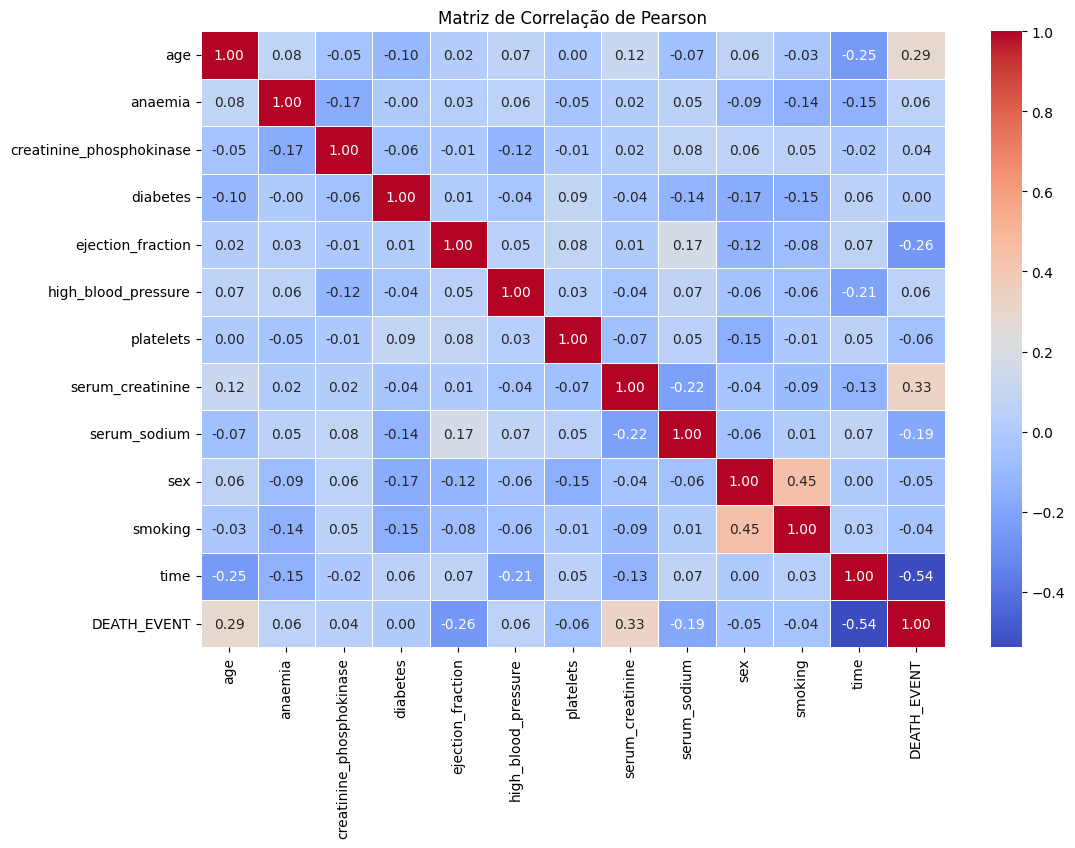

In [425]:
# Calcular a correlação de Spearman
cp = train_data.corr(method='pearson')

# Plotar a matriz de correlação
plt.figure(figsize=(12, 8))
sns.heatmap(cp, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlação de Pearson')
plt.show()

#### 2.2 Análise das Distribuições das variáveis numéricas

In [426]:
# Resumo estatístico das variáveis
distribution = ['age','creatinine_phosphokinase','ejection_fraction','platelets','serum_creatinine','serum_sodium','time']
flags = ['anaemia','diabetes','high_blood_pressure','sex','smoking','DEATH_EVENT']

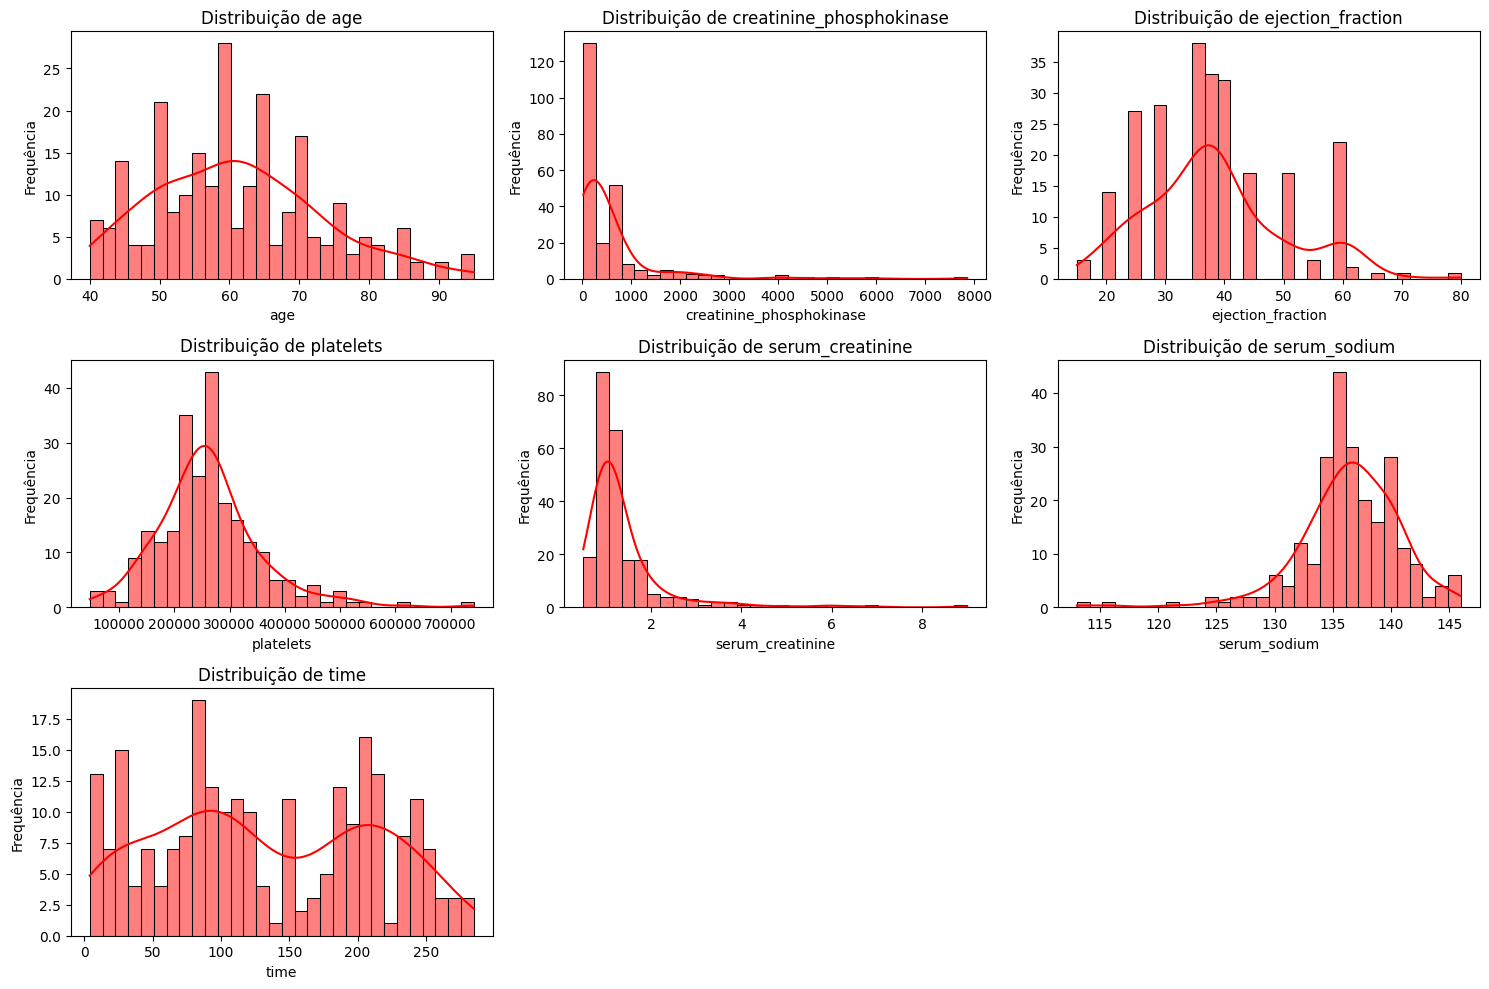

In [427]:
# Definir o tamanho da figura
plt.figure(figsize=(15, 10))

# Criar um subplot para cada variável
for i, var in enumerate(distribution, 1):
    plt.subplot(3, 3, i)  # Organizar os gráficos em 3x3 (ajustar conforme necessário)
    sns.histplot(X_train[var], kde=True, bins=30, color='red', edgecolor='black')  # Histograma com KDE
    plt.title(f'Distribuição de {var}')
    plt.xlabel(var)
    plt.ylabel('Frequência')

# Ajustar o layout para não sobrepor os gráficos
plt.tight_layout()
plt.show()


###### A única variável que não é contínua nesse conjunto é ejection_fraction, e ele será utilizada de maneira diferente nos processos a seguir.

In [428]:
var_simetria = ['age','creatinine_phosphokinase','platelets','serum_creatinine','serum_sodium','time']
var_bin = ['ejection_fraction']

#### 2.3 Assimetria e Curtose

In [429]:
# Calculando assimetria (skewness) e curtose (kurtosis)
asimetria_curtose = pd.DataFrame({
    'Variável': var_simetria,
    'Assimetria': X_train[var_simetria].skew(),
    'Curtose': X_train[var_simetria].kurtosis()
}).reset_index(drop=True)

# Exibindo o resultado
print(asimetria_curtose)


                   Variável  Assimetria    Curtose
0                       age    0.456810  -0.114925
1  creatinine_phosphokinase    4.160973  22.179139
2                 platelets    1.112034   3.488498
3          serum_creatinine    4.053323  21.335515
4              serum_sodium   -1.296990   4.792745
5                      time    0.084421  -1.221268


###### Para reduzir principalmente a curtose de algumas variáveis (presença de muitos valore Outliers), vou utilizar a transformação logarítmica para diminuir significativamente os valores extremos

##### 2.4 **`serum_creatinine`**,  **`serum_sodium`** e **`creatinine_phosphokinase`**

In [430]:
# Box-Cox
# Aplicando Box-Cox no X_train e obtendo o lambda
X_train['serum_creatinine'], lambda_creatinine = stats.boxcox(X_train['serum_creatinine'])
X_train['serum_sodium'], lambda_sodium = stats.boxcox(X_train['serum_sodium'])
X_train['creatinine_phosphokinase'], lambda_creatinine_phosphokinase = stats.boxcox(X_train['creatinine_phosphokinase'])

# Aplicando Box-Cox no X_test com o mesmo lambda
X_test['serum_creatinine'] = stats.boxcox(X_test['serum_creatinine'], lmbda=lambda_creatinine)
X_test['serum_sodium'] = stats.boxcox(X_test['serum_sodium'],lmbda=lambda_sodium)
X_test['creatinine_phosphokinase'] = stats.boxcox(X_test['creatinine_phosphokinase'],lmbda=lambda_creatinine_phosphokinase)


##### 2.5 **`ejection_fraction`**

In [431]:
# Definindo o discretizador
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')

# Selecionando a variável de interesse para discretização
ejection_fraction_train = X_train[['ejection_fraction']]

# Aplicando o discretizador no X_train
X_train['ejection_fraction'] = discretizer.fit_transform(ejection_fraction_train)

# Aplicando o discretizador no X_test com a mesma transformação
ejection_fraction_test = X_test[['ejection_fraction']]
X_test['ejection_fraction'] = discretizer.transform(ejection_fraction_test)


In [432]:
# Combine os dados de treino
train_data_pt = pd.concat([X_train, y_train], axis=1)

##### 2.6 Correlação de Pearson após Transformações

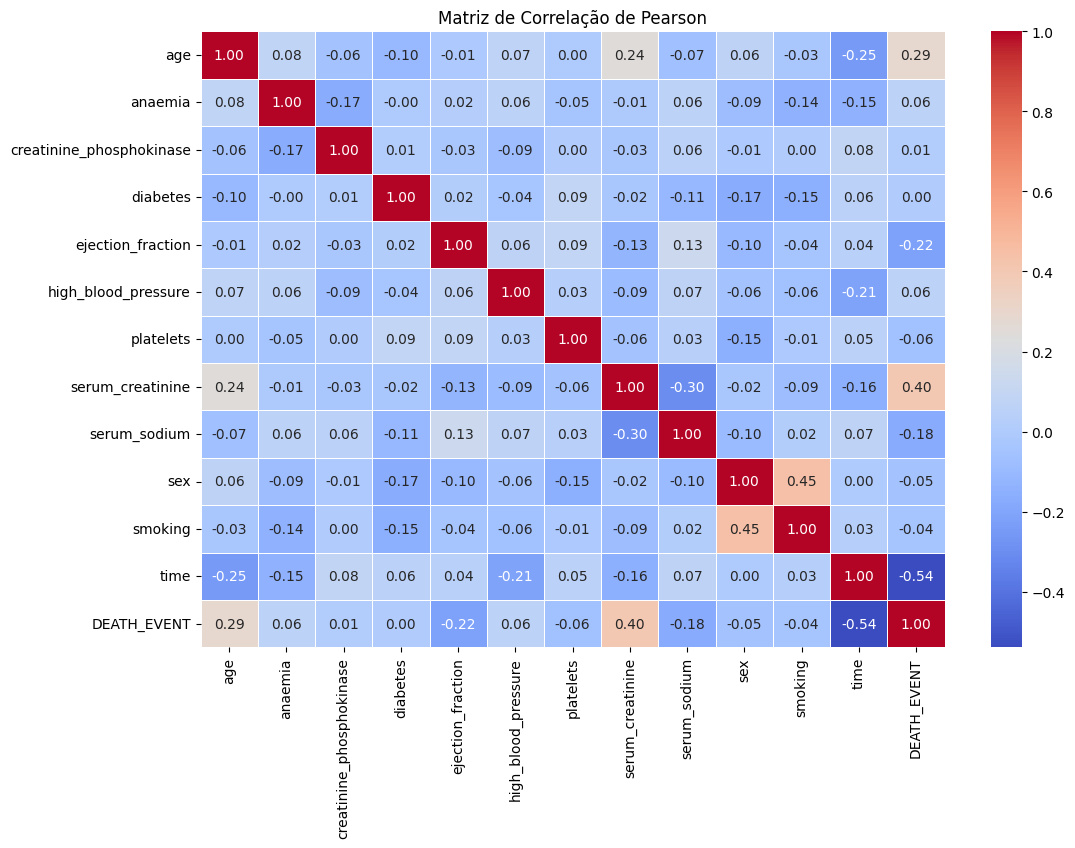

In [433]:
# Calcular a correlação de Spearman
cp = train_data_pt.corr(method='pearson')

# Plotar a matriz de correlação
plt.figure(figsize=(12, 8))
sns.heatmap(cp, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlação de Pearson')
plt.show()

#### 3. Feature Enginnering

###### Nessa etapa vamos explorar a utilização da biblioteca Feature-Engine para a criação de features automáticas com o objetivo de otimizar ainda mais as variáveis no dataset

###### A Feature-engine é uma biblioteca Python projetada para facilitar o processo de engenharia de features em datasets tabulares, com foco em pré-processamento, transformação e criação de novas features. Ela fornece uma série de ferramentas para melhorar a qualidade e a performance do modelo de machine learning por meio da manipulação das variáveis.

In [434]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 239 entries, 6 to 102
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       239 non-null    float64
 1   anaemia                   239 non-null    int64  
 2   creatinine_phosphokinase  239 non-null    float64
 3   diabetes                  239 non-null    int64  
 4   ejection_fraction         239 non-null    float64
 5   high_blood_pressure       239 non-null    int64  
 6   platelets                 239 non-null    float64
 7   serum_creatinine          239 non-null    float64
 8   serum_sodium              239 non-null    float64
 9   sex                       239 non-null    int64  
 10  smoking                   239 non-null    int64  
 11  time                      239 non-null    int64  
dtypes: float64(6), int64(6)
memory usage: 24.3 KB


In [435]:
renal = ['serum_creatinine','creatinine_phosphokinase']
metabolica = ['platelets','creatinine_phosphokinase']
deseq = ['serum_sodium','serum_creatinine']
risk = ['high_blood_pressure','diabetes']
time_renal = ['time','serum_creatinine']

#Combinação com Somas
math_sum = MathFeatures(variables=renal, func='sum')
X_train = math_sum.fit_transform(X_train)
X_test = math_sum.fit_transform(X_test) #Aplicando no X_test

math_sum = MathFeatures(variables=deseq, func='sum')
X_train = math_sum.fit_transform(X_train)
X_test = math_sum.fit_transform(X_test) #Aplicando no X_test

math_prod = MathFeatures(variables=time_renal, func='prod')
X_train = math_prod.fit_transform(X_train)
X_test = math_prod.fit_transform(X_test)

#Combinação com produtos
math_prod = MathFeatures(variables=metabolica, func='prod')
X_train = math_prod.fit_transform(X_train)
X_test = math_prod.fit_transform(X_test)

math_prod = MathFeatures(variables=risk, func='prod')
X_train = math_prod.fit_transform(X_train)
X_test = math_prod.fit_transform(X_test)


In [436]:
# Combine os dados de treino
train_data_fe = pd.concat([X_train, y_train], axis=1)

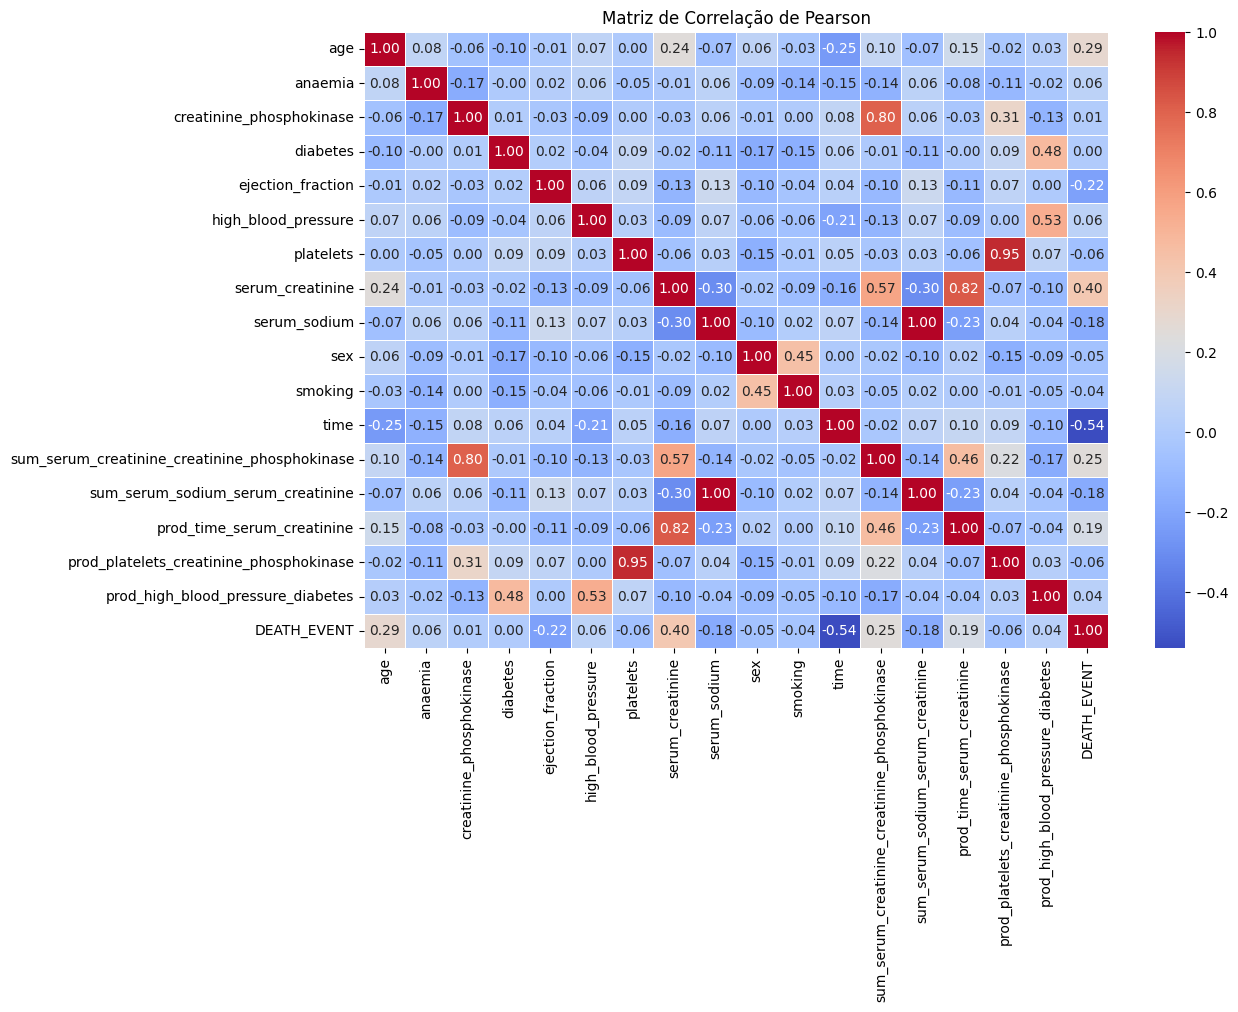

In [437]:
# Calcular a correlação de Spearman
cp_autofeatures = train_data_fe.corr(method='pearson')

# Plotar a matriz de correlação
plt.figure(figsize=(12, 8))
sns.heatmap(cp_autofeatures, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlação de Pearson')
plt.show()

##### 4. Treinamento do Modelo

#### 4.1 **Decision Tree**

In [454]:
# Instanciando o modelo
clf_tree = DecisionTreeClassifier(max_depth=5, min_samples_split=10, random_state=42)

# Treinando o modelo
decision_tree = clf_tree.fit(X_train, y_train)

# Fazendo as previsões
y_pred_tree = decision_tree.predict(X_test)

# Avaliando o modelo
accuracy_tree = accuracy_score(y_test, y_pred_tree)
print(f'Acurácia da Árvore de Decisão: {accuracy_tree}')
print(classification_report(y_test, y_pred_tree))


Acurácia da Árvore de Decisão: 0.6833333333333333
              precision    recall  f1-score   support

           0       0.69      0.83      0.75        35
           1       0.67      0.48      0.56        25

    accuracy                           0.68        60
   macro avg       0.68      0.65      0.66        60
weighted avg       0.68      0.68      0.67        60



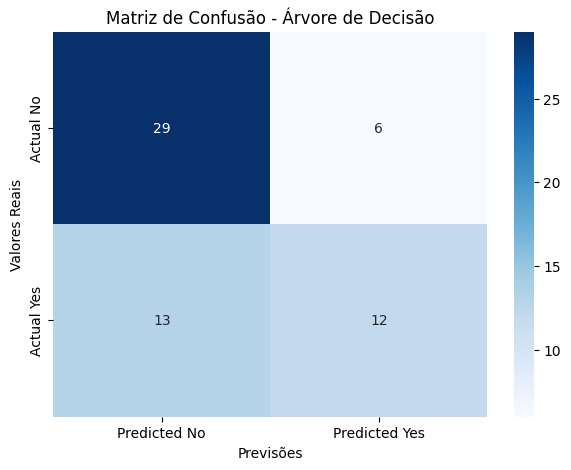

In [455]:
cm = confusion_matrix(y_test, y_pred_tree)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted No', 'Predicted Yes'], yticklabels=['Actual No', 'Actual Yes'])
plt.title('Matriz de Confusão - Árvore de Decisão')
plt.xlabel('Previsões')
plt.ylabel('Valores Reais')
plt.show()

##### 4.2 **Random Forest**

In [456]:
# Instanciando o modelo
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Treinando o modelo
random_forest = clf_rf.fit(X_train, y_train)

# Fazendo as previsões
y_pred_rf = random_forest.predict(X_test)

# Avaliando o modelo
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Acurácia do Random Forest: {accuracy_rf}')
print(classification_report(y_test, y_pred_rf))


Acurácia do Random Forest: 0.7166666666666667
              precision    recall  f1-score   support

           0       0.70      0.89      0.78        35
           1       0.75      0.48      0.59        25

    accuracy                           0.72        60
   macro avg       0.73      0.68      0.69        60
weighted avg       0.72      0.72      0.70        60



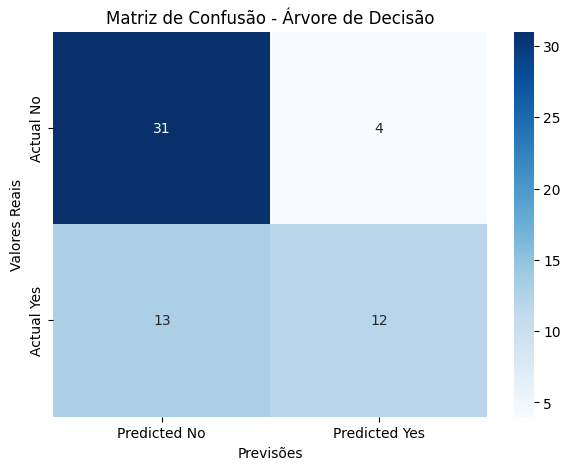

In [457]:
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(7, 5))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted No', 'Predicted Yes'], yticklabels=['Actual No', 'Actual Yes'])
plt.title('Matriz de Confusão - Árvore de Decisão')
plt.xlabel('Previsões')
plt.ylabel('Valores Reais')
plt.show()

##### 4.3 **XGBoost**

In [458]:
# Instanciando o modelo
clf_xgb = xgb.XGBClassifier(random_state=42)

# Treinando o modelo
xg_boost = clf_xgb.fit(X_train, y_train)

# Fazendo as previsões
y_pred_xgb = xg_boost.predict(X_test)

# Avaliando o modelo
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f'Acurácia do XGBoost: {accuracy_xgb}')
print(classification_report(y_test, y_pred_xgb))

Acurácia do XGBoost: 0.7666666666666667
              precision    recall  f1-score   support

           0       0.77      0.86      0.81        35
           1       0.76      0.64      0.70        25

    accuracy                           0.77        60
   macro avg       0.77      0.75      0.75        60
weighted avg       0.77      0.77      0.76        60



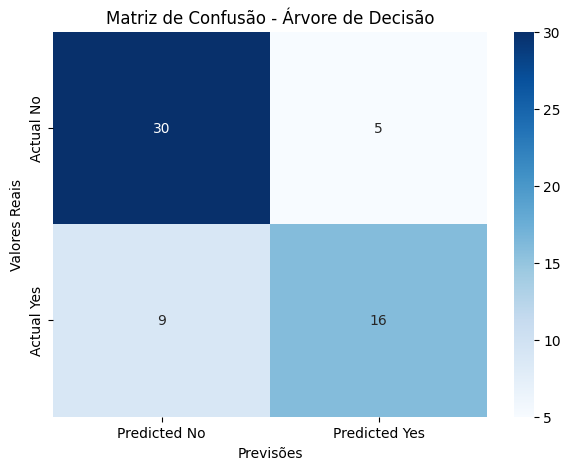

In [460]:
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(7, 5))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted No', 'Predicted Yes'], yticklabels=['Actual No', 'Actual Yes'])
plt.title('Matriz de Confusão - Árvore de Decisão')
plt.xlabel('Previsões')
plt.ylabel('Valores Reais')
plt.show()

##### 5. Otimização do Modelo **XGBoost**